# Machine Learning con PySpark & MLflow Tracking

Questo notebook implementa **due modelli di machine learning distribuito** utilizzando PySpark MLlib, con tracking completo degli esperimenti tramite MLflow:

1. **ALS Recommendation System** - Sistema di raccomandazione prodotti basato su Collaborative Filtering
2. **Random Forest Classifier** - Classificazione customer segment per marketing personalizzato

Utilizzeremo un approccio a due fasi per ottimizzare i tempi:

**Development Phase (20% data)**:
- Esplorazione iperparametri su sample
- Identificazione configurazioni promettenti
- Training veloce per iterazioni rapide

**Production Phase (100% data)**:
- Re-training su dataset completo
- Valutazione finale
- Selezione del modello definitivo


**Tutti** gli esperimenti saranno tracciati in **MLflow**:
- Parameters (configurazioni modelli)
- Metrics (performance)
- Models (artifacts)
- Tags (development/production)

Lo scopo finale è selezionare i migliori modelli per deployment production.


In [1]:
# IMPORT & ENVIRONMENT SETUP

import os
import sys
import time
import json
import itertools
import logging
import warnings
import requests
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# MLlib
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


# MLflow
import mlflow
import mlflow.spark
from mlflow.tracking import MlflowClient

# Configuration
sys.path.append(str(Path.cwd().parent))
from config.spark_config import get_spark_session
from config.mlflow_config import setup_mlflow, get_mlflow_client, log_model


# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Environment variables
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

# Silence Warning Log
logging.getLogger("org").setLevel(logging.ERROR)
logging.getLogger("py4j").setLevel(logging.ERROR)

# Training Configuration
SAMPLE_FRACTION_DEV = 0.2
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
RANDOM_SEED = 42
TOP_N = 3

# Delta Lake paths
DATA_PATHS = {
    'user_item_interactions': 's3a://bigdata-ecommerce/ml_data/user_item_interactions',
    'customer_features': 's3a://bigdata-ecommerce/ml_data/customer_features',
    'predictions': 's3a://bigdata-ecommerce/ml_predictions',
}

# Results Directory
RESULTS_DIR = Path("../docs/results")
GRAPH_DIR = Path("../docs/graphs")

print("All imports successful!")
print(f"  Python version: {sys.version.split()[0]}")
print(f"  Pandas version: {pd.__version__}")
print(f"  MLflow version: {mlflow.__version__}")

All imports successful!
  Python version: 3.10.19
  Pandas version: 2.3.3
  MLflow version: 2.9.2


In [2]:
# PREREQUISITES CHECK

print("=" * 70)
print("PREREQUISITES CHECK")
print("="*70 + "\n")

# Check MLflow server
try:
    response = requests.get("http://localhost:5000", timeout=5)
    if response.status_code == 200:
        print("  MLflow server: RUNNING (http://localhost:5000)")
    else:
        print("  MLflow server: NOT RESPONDING")
        raise Exception("MLflow server not accessible")
except Exception as e:
    print(f"  MLflow server: ERROR - {e}")
    raise

# Check MinIO
try:
    response = requests.get("http://localhost:9000/minio/health/live", timeout=5)
    if response.status_code == 200:
        print("  MinIO server: RUNNING (http://localhost:9000)")
    else:
        print("  MinIO server: NOT RESPONDING")
except Exception as e:
    print(f"  MinIO server: WARNING - {e}")


print("\n  All prerequisites OK!")

PREREQUISITES CHECK

  MLflow server: RUNNING (http://localhost:5000)
  MinIO server: RUNNING (http://localhost:9000)

  All prerequisites OK!


In [3]:
# MLFLOW EXPERIMENT SETUP

print("=" * 70)
print("MLFLOW EXPERIMENT SETUP")
print("="*70 + "\n")

# Setup MLflow 
MLFLOW_EXPERIMENT_NAME = "ecommerce-ml-models"
experiment_id = setup_mlflow(MLFLOW_EXPERIMENT_NAME)

# Get MLflow client
client = get_mlflow_client()

# Verify experiment
experiment = client.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)

print(f"\nMLflow experiment ready")

MLFLOW EXPERIMENT SETUP

S3 client configured for MinIO at localhost:9000
Using existing experiment: ecommerce-ml-models (ID: 1)
MLflow UI: http://localhost:5000
Artifacts Location: s3://bigdata-ecommerce/mlflow-artifacts/

MLflow experiment ready


## Dataset Overview

I dataset per il machine learning sono stati preparati nel Notebook 3:

### 1. User-Item Interactions (per ALS)
**Path**: `s3a://bigdata-ecommerce/ml_data/user_item_interactions`

**Schema**:
- `user_id` (string): Customer ID
- `item_id` (string): Product ID
- `rating` (double): Rating implicito derivato dalle transazioni
- `timestamp` (timestamp): Transaction timestamp

**Size**: ~100M interactions

**Uso**: Collaborative Filtering per raccomandazioni personalizzate

### 2. Customer Features (per Random Forest)
**Path**: `s3a://bigdata-ecommerce/ml_data/customer_features`

**Schema**:
- `customer_id` (string): Customer ID
- `recency` (int): Giorni dall'ultimo acquisto
- `frequency` (int): Numero totale di acquisti
- `monetary` (double): Spesa totale
- `avg_transaction` (double): Valore medio transazione
- `customer_segment` (string): Segmento (VIP/Regular/Occasional) **← LABEL**
- `age` (int): Età cliente
- `region` (string): Regione geografica

**Size**: ~1M customers

**Uso**: Classificazione segmenti per targeting marketing


# PySpark MLlib & MLFlow Tracking

## Architettura MLlib

**MLlib** è la libreria di Machine Learning distribuito di Spark, progettata per scalare su dataset di grandi dimensioni.

1. **DataFrame-based API** (high-level)
   - Integrata con Spark SQL
   - Type-safe e ottimizzata
   - API simile a scikit-learn

2. **Pipeline API**
   - Composizione di trasformazioni
   - Riproducibilità garantita
   - Fit-Transform pattern

3. **ML Algorithms**
   - Classification: Random Forest, Logistic Regression, GBT, etc.
   - Regression: Linear Regression, Random Forest Regression, etc.
   - Clustering: K-Means, Gaussian Mixture, etc.
   - Collaborative Filtering: ALS

4. **Feature Engineering**
   - Transformers: VectorAssembler, StringIndexer, etc.
   - Feature extraction, selection, normalization

## Pipeline API

L'API Pipeline di MLlib consente di creare workflow ML riproducibili e modulari.

**Transformer**:
- Trasforma un DataFrame in un altro
- Metodo: `transform()`
- Esempi: VectorAssembler, StringIndexer, Model (trained)

**Estimator**:
- Addestra su dati e produce un Transformer
- Metodo: `fit()` → Model (Transformer)
- Esempi: LogisticRegression, RandomForest, ALS

**Pipeline**:
- Sequenza di Transformers ed Estimators
- `fit()` esegue tutti gli stage in ordine
- Produce un PipelineModel (Transformer)

**Pattern Tipico**

Data → Feature Engineering (Transformers) → ML Algorithm (Estimator) → Predictions

## Metriche di Valutazione

MLlib fornisce evaluators specializzati per diversi tipi di task.

### Regression Metrics (ALS)

**RMSE** (Root Mean Squared Error):
- Penalizza maggiormente errori grandi
- Stesso range dei rating (0-5)

**MAE** (Mean Absolute Error):
- Errore medio assoluto
- Meno sensibile a outliers di RMSE

### Classification Metrics (Random Forest)

**Accuracy**:
- Proporzione di predizioni corrette
- Range: 0-1

**F1 Score**:
- Media armonica di precision e recall
- Bilanciamento tra falsi positivi e falsi negativi

## MLFlow Tracking

**MLflow** traccia e salva tutti i training eseguiti fornendo una panoramica chiara dei modelli addestrati, confrontarli ed estrarre quello desisderato in qualsiasi momento. 

**Pattern Tipico**

1. **Set tags**
   - `mlflow.set_tag("phase", "development" or "production")`
   - `mlflow.set_tag("model_type", "ALS" or "RF")`
   - `mlflow.set_tag("sample_fraction", 0.2 or 1.0)`

2. **Log parameters**
   - `mlflow.log_param("param1", value1)`
   - `mlflow.log_param("param2", value2)`

3. **Train model**
   - `model = algorithm.fit(train_data)`
    
4. **Evaluate**
   - `predictions = model.transform(test_data)`
   - `metric = evaluator.evaluate(predictions)`

5. **Log metrics**
   - `mlflow.log_metric("primary_metric", metric)`
   - `mlflow.log_metric("train_time_seconds", time)`

# ALS Recommendation System

## Alternating Least Squares (ALS)

**ALS** è un algoritmo di Collaborative Filtering per sistemi di raccomandazione.

### Come Funziona

1. **Matrix Factorization**:
   - User-Item rating matrix (sparse) → Due matrici di fattori latenti (dense)
   - User factors (U): caratteristiche utenti
   - Item factors (I): caratteristiche prodotti
   - Predizione: `rating ≈ U × I`

2. **Alternating Optimization**:
   - Fissa U, ottimizza I
   - Fissa I, ottimizza U
   - Alterna fino a convergenza

3. **Implicit Feedback**:
   - Il nostro caso: rating impliciti da transazioni
   - Non abbiamo rating espliciti (1-5 stelle)
   - Usiamo frequenza acquisti, importo speso, etc.

### Use Case E-commerce

**Obiettivo**: Raccomandare prodotti agli utenti basandosi su:
- Prodotti acquistati in passato
- Comportamento di utenti simili
- Popolarità dei prodotti

**Output**: Top-N prodotti raccomandati per ogni utente

### Iperparametri

**rank**: Numero di fattori latenti (5-15)  
**maxIter**: Iterazioni ALS (10-20)  
**regParam**: Regularization (0.01-1.0) - previene overfitting  


## Development Phase - Esplorazione Iperparametri

La fase di development usa un **sample del 20%** del dataset per:
- Esplorare rapidamente lo spazio degli iperparametri
- Identificare configurazioni promettenti
- Ridurre i tempi di training

### Grid Search Strategy

Testeremo **27 combinazioni**:
- `rank`: [5, 10, 15] - dimensionalità fattori latenti
- `maxIter`: [10, 15, 20] - numero iterazioni
- `regParam`: [0.01, 0.1, 1.0] - regolarizzazione

### MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=0.2`, `model_type=ALS`
- **Params**: rank, maxIter, regParam
- **Metrics**: RMSE, MAE, train_time


In [5]:
#  SPARK SESSION CREATION

print("=" * 70)
print("SPARK SESSION CREATION")
print("="*70 + "\n")

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")

SPARK SESSION CREATION

Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Spark session created successfully


In [6]:
# LOAD & SPLIT SAMPLE DATA (20%)

print("=" * 70)
print("ALS DEVELOPMENT PHASE (20% SAMPLE)")
print("="*70 + "\n")

print(f"Development configuration:")
print(f"  Sample fraction: {SAMPLE_FRACTION_DEV} ({SAMPLE_FRACTION_DEV*100:.0f}%)")
print(f"  Train/test split: {TRAIN_RATIO}/{TEST_RATIO}")
print(f"  Random seed: {RANDOM_SEED}")

# Load user-item interactions (for ALS)
print("\nLoading user-item interactions...")
try:
    interactions_full = spark.read.format("delta").load(DATA_PATHS['user_item_interactions'])
    interactions_count = interactions_full.count()
    print(f"Loaded {interactions_count:,} interactions")
    print(f"Schema:")
    interactions_full.printSchema()
    
except Exception as e:
    print(f"Error loading interactions: {e}")
    raise

# Load sample
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()

interactions_dev = interactions_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
interactions_dev.cache()

dev_count = interactions_dev.count()
load_time = time.time() - start_time

print(f"  Sample loaded: {dev_count:,} interactions")
print(f"  Load time: {load_time:.1f} seconds")
print(f"  Memory: Cached for faster access")

# Quick statistics
print("\nSample statistics:")
print(f"  Unique customers: {interactions_dev.select('customer_id').distinct().count():,}")
print(f"  Unique products: {interactions_dev.select('product_id').distinct().count():,}")
print(f"  Rating range: [{interactions_dev.agg(F.min('rating')).collect()[0][0]:.2f}, {interactions_dev.agg(F.max('rating')).collect()[0][0]:.2f}]")

print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (DEVELOPMENT)")
print("="*70 + "\n")

# Split Data
print(f"Splitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev, test_dev = interactions_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# Cache for reuse
train_dev.cache()
test_dev.cache()

# Counts
train_dev_count = train_dev.count()
test_dev_count = test_dev.count()

print(f"  Split complete")
print(f"  Train set: {train_dev_count:,} interactions ({train_dev_count/dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_count:,} interactions ({test_dev_count/dev_count*100:.1f}%)")
print(f"\nData ready for training")


ALS DEVELOPMENT PHASE (20% SAMPLE)

Development configuration:
  Sample fraction: 0.2 (20%)
  Train/test split: 0.8/0.2
  Random seed: 42

Loading user-item interactions...
Loaded 73,874,174 interactions
Schema:
root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- total_spent: double (nullable = true)


Loading 20% sample for development...
  Sample loaded: 14,774,318 interactions
  Load time: 14.1 seconds
  Memory: Cached for faster access

Sample statistics:
  Unique customers: 999,876
  Unique products: 50,000
  Rating range: [2.15, 12.63]

TRAIN/TEST SPLIT (DEVELOPMENT)

Splitting data (0.8/0.2)...
  Split complete
  Train set: 11,818,119 interactions (80.0%)
  Test set: 2,956,199 interactions (20.0%)

Data ready for training


## Grid Search

Eseguiamo una grid search sistematica per esplorare lo spazio degli iperparametri.

### Metriche di Interesse

**RMSE**:
- Obiettivo: minimizzare errore di predizione
- Target: RMSE < 1.0

**Training Time**:
- Monitoriamo per considerazioni di scalabilità
- Modelli più complessi (high rank, high iter) richiedono più tempo

### Cold Start Strategy

**coldStartStrategy="drop"**:
- Gestione di user/item non visti nel training

In [7]:
# GRID SEARCH LOOP WITH MLFLOW

print("=" * 70)
print("ALS HYPERPARAMETER GRID SEARCH (DEVELOPMENT)")
print("="*70 + "\n")

# Define hyperparameter grid
param_grid = {
    'rank': [5, 10, 15],
    'maxIter': [10, 15, 20],
    'regParam': [0.01, 0.1, 1.0]
}

# Generate all combinations
all_combinations = list(itertools.product(
    param_grid['rank'],
    param_grid['maxIter'],
    param_grid['regParam']
))

# Number of combinations
n_combinations = len(all_combinations)

print(f"Hyperparameter grid:")
print(f"  rank: {param_grid['rank']}")
print(f"  maxIter: {param_grid['maxIter']}")
print(f"  regParam: {param_grid['regParam']}")
print(f"\nTotal combinations: {n_combinations}")

# Initialize results storage
results_dev_als = []

# ALS evaluator
rmse_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

mae_evaluator = RegressionEvaluator(
    metricName="mae",
    labelCol="rating",
    predictionCol="prediction"
)

print("\n" + "-" * 70)
print(f"Starting grid search...")
print("-" * 70)

# Grid search
for i, (rank, maxIter, regParam) in enumerate(all_combinations, 1): 
    
    run_name = f"ALS_dev_r{rank}_i{maxIter}_reg{regParam}"
    
    print(f"\n[{i}/{n_combinations}] Training: {run_name}\n")     
    
    # Train
    train_start = time.time()
    
    als = ALS(
        rank=rank,
        maxIter=maxIter,
        regParam=regParam,
        userCol="user_id",
        itemCol="item_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        seed=RANDOM_SEED
    )
    
    model = als.fit(train_dev)
    train_time = time.time() - train_start

    # Evaluate
    predictions = model.transform(test_dev)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    
    # Tags
    tags = {
        "phase": "development",
        "model_type": "ALS",
        "sample_fraction": SAMPLE_FRACTION_DEV
    }

    # Params
    params = {
        "rank": rank,
        "maxIter": maxIter,
        "regParam": regParam,
        "coldStarStrategy": "drop"
    }

    # Metrics
    metrics ={
        "rmse": rmse,
        "mae": mae,
        "train_time": train_time
    }

    # Log model
    log_model(
        run_name=run_name, 
        model_name="ALS_dev", 
        model=model, 
        metrics=metrics, 
        params=params, 
        tags=tags
    ) 

    # Store results
    results_dev_als.append({
        'rank': rank,
        'maxIter': maxIter,
        'regParam': regParam,
        'rmse': rmse,
        'mae': mae,
        'train_time': train_time
    })
    print("\n  Metrics:")
    print(f"    RMSE={rmse:.4f}, MAE={mae:.4f}, Time={train_time:.1f}s")

print("\nGrid Search complete")

ALS HYPERPARAMETER GRID SEARCH (DEVELOPMENT)

Hyperparameter grid:
  rank: [5, 10, 15]
  maxIter: [10, 15, 20]
  regParam: [0.01, 0.1, 1.0]

Total combinations: 27

----------------------------------------------------------------------
Starting grid search...
----------------------------------------------------------------------

[1/27] Training: ALS_dev_r5_i10_reg0.01

  Spark model logged to MLflow
    Run ID: a4cda0a895be4128ba0b3afc5d5ebfc9
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/a4cda0a895be4128ba0b3afc5d5ebfc9/

  Metrics:
    RMSE=0.6708, MAE=0.3956, Time=48.8s

[2/27] Training: ALS_dev_r5_i10_reg0.1

  Spark model logged to MLflow
    Run ID: 51acee06b9a04e829c5178b38ddbe3ee
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/51acee06b9a04e829c5178b38ddbe3ee/

  Metrics:
    RMSE=0.5559, MAE=0.3620, Time=46.2s

[3/27] Training: ALS_dev_r5_i10_reg1.0

  Spark model logged to MLflow
    Run ID: 091b0f71ca8f460a90ebb39968a1b8b5
    Artifacts in 

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare pattern e selezionare le migliori tre configurazioni basadoci su:.

1. **RMSE** (primario): Valore più basso
2. **Training time** (secondario): A parità di RMSE, preferiamo model più veloci
3. **Generalizzazione**: Configurazioni non troppo complesse (evitare overfitting)

Le top 3 configs selzionate saranno ri-trainate su **100% data** nella fase di production.

COLLECTING DEVELOPMENT RESULTS

Total configurations tested: 27

Best 5 configurations (by RMSE):
              run_name model_type  rank  maxIter  regParam coldStarStrategy     rmse      mae  train_time
ALS_dev_r15_i20_reg0.1        ALS    15       20       0.1             drop 0.519804 0.341464  211.702522
ALS_dev_r15_i15_reg0.1        ALS    15       15       0.1             drop 0.521741 0.342595  162.634185
ALS_dev_r10_i20_reg0.1        ALS    10       20       0.1             drop 0.523069 0.343234  145.743097
ALS_dev_r15_i10_reg0.1        ALS    15       10       0.1             drop 0.524771 0.344647  108.484507
ALS_dev_r10_i15_reg0.1        ALS    10       15       0.1             drop 0.526987 0.345503  111.741918

Worst 5 configurations (by RMSE):
              run_name model_type  rank  maxIter  regParam coldStarStrategy     rmse      mae  train_time
ALS_dev_r10_i15_reg1.0        ALS    10       15       1.0             drop 1.137999 0.999565  109.855141
 ALS_dev_r5_i15_reg

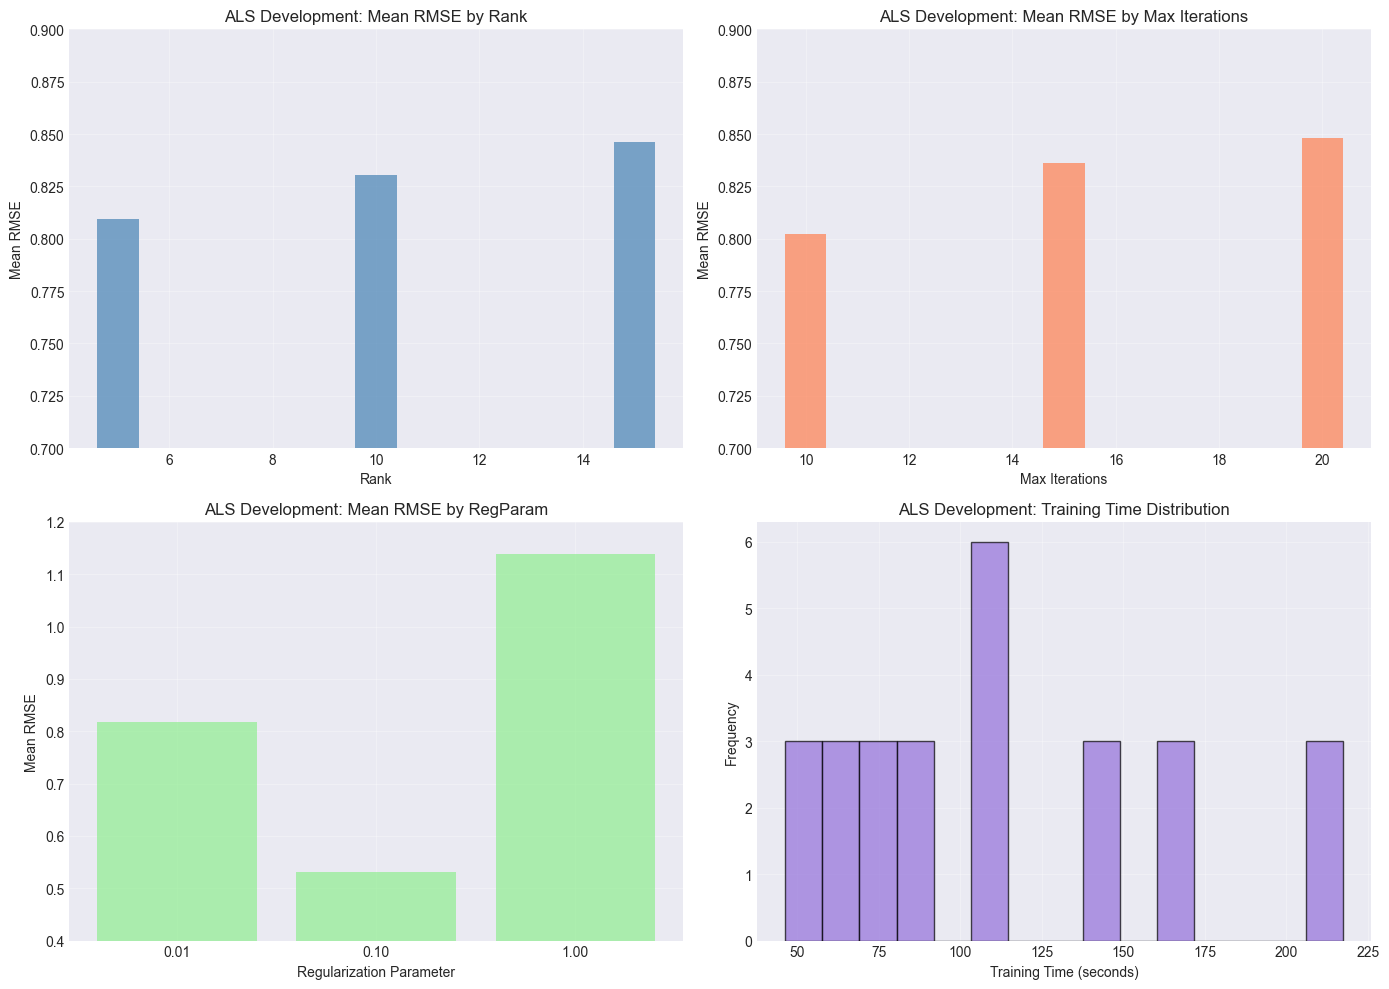


SAVING DEVELOPMENT RESULTS

Saved CSV: 04_als_development_tuning.csv
  Rows: 27
  Columns: ['run_name', 'model_type', 'rank', 'maxIter', 'regParam', 'coldStarStrategy', 'rmse', 'mae', 'train_time']

SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION

Top 3 configurations selected:

1. rank=15, maxIter=20, regParam=0.1
  Development RMSE: 0.5198
  Development MAE: 0.3415
  Development train time: 211.7s

2. rank=15, maxIter=15, regParam=0.1
  Development RMSE: 0.5217
  Development MAE: 0.3426
  Development train time: 162.6s

3. rank=10, maxIter=20, regParam=0.1
  Development RMSE: 0.5231
  Development MAE: 0.3432
  Development train time: 145.7s


CLEANUP

Caches cleared
Spark Session stopped


In [8]:
# DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS")
print("="*70 + "\n")

# Get all runs
als_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'development'" 
)

# Extract run data
runs_data = []
for run in als_dev_runs:

    run_data = {'run_name': run.info.run_name}
    
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']
    
    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)

# Convert to DataFrame
results_dev_als_df = pd.DataFrame(runs_data)
runs_data


results_dev_als_df['rank'] = results_dev_als_df['rank'].astype(int)
results_dev_als_df['maxIter'] = results_dev_als_df['maxIter'].astype(int)
results_dev_als_df['regParam'] = results_dev_als_df['regParam'].astype(float)

# Sort by RMSE (ascending - lower is better)
results_dev_als_df = results_dev_als_df.sort_values('rmse', ascending=True).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_als_df)}")
print(f"\nBest 5 configurations (by RMSE):")
print(results_dev_als_df.head(5).to_string(index=False))

print(f"\nWorst 5 configurations (by RMSE):")
print(results_dev_als_df.tail(5).to_string(index=False))

# Statistics
print(f"\nResults statistics:")
print(f"  Best RMSE: {results_dev_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_dev_als_df['rmse'].max():.4f}")
print(f"  Mean RMSE: {results_dev_als_df['rmse'].mean():.4f}")
print(f"  Std RMSE: {results_dev_als_df['rmse'].std():.4f}")
print(f"  Avg train time: {results_dev_als_df['train_time'].mean():.1f}s")

# Analyze Development Results

print("\n" + "=" * 70)
print("DEVELOPMENT RESULTS ANALYSIS")
print("="*70 + "\n")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: RMSE by rank
ax1 = axes[0, 0]
rank_groups = results_dev_als_df.groupby('rank')['rmse'].mean().sort_index()
ax1.bar(rank_groups.index, rank_groups.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Mean RMSE')
ax1.set_title('ALS Development: Mean RMSE by Rank')
ax1.set_ylim(0.7, 0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: RMSE by maxIter
ax2 = axes[0, 1]
iter_groups = results_dev_als_df.groupby('maxIter')['rmse'].mean().sort_index()
ax2.bar(iter_groups.index, iter_groups.values, color='coral', alpha=0.7)
ax2.set_xlabel('Max Iterations')
ax2.set_ylabel('Mean RMSE')
ax2.set_title('ALS Development: Mean RMSE by Max Iterations')
ax2.set_ylim(0.7, 0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: RMSE by regParam
ax3 = axes[1, 0]
reg_groups = results_dev_als_df.groupby('regParam')['rmse'].mean().sort_index()
ax3.bar(range(len(reg_groups)), reg_groups.values, color='lightgreen', alpha=0.7)
ax3.set_xticks(range(len(reg_groups)))
ax3.set_xticklabels([f'{x:.2f}' for x in reg_groups.index])
ax3.set_xlabel('Regularization Parameter')
ax3.set_ylabel('Mean RMSE')
ax3.set_title('ALS Development: Mean RMSE by RegParam')
ax3.set_ylim(0.4, 1.2)
ax3.grid(True, alpha=0.3)

# Plot 4: Training time distribution
ax4 = axes[1, 1]
ax4.hist(results_dev_als_df['train_time'], bins=15, color='mediumpurple', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Training Time (seconds)')
ax4.set_ylabel('Frequency')
ax4.set_title('ALS Development: Training Time Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_als_development_analysis.png', dpi=300, bbox_inches='tight')
print("Saved PNG: 04_als_development_analysis.png")
plt.show()


print("\n" + "=" * 70)
print("SAVING DEVELOPMENT RESULTS")
print("="*70 + "\n")

# Save complete results
results_dev_als_df.to_csv(RESULTS_DIR / '04_als_development_tuning.csv', index=False)
print(f"Saved CSV: 04_als_development_tuning.csv")
print(f"  Rows: {len(results_dev_als_df)}")
print(f"  Columns: {list(results_dev_als_df.columns)}")


print("\n" + "=" * 70)
print("SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION")
print("="*70 + "\n")

# Select top configurations
top_als_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'development'",
    order_by=[f"metrics.rmse ASC"],
    max_results=TOP_N 
)

print(f"Top {TOP_N} configurations selected:\n")
for i, run in enumerate(top_als_runs, 1):
    print(f"{i}. rank={run.data.params['rank']}, maxIter={run.data.params['maxIter']}, regParam={run.data.params['regParam']}")
    print(f"  Development RMSE: {run.data.metrics['rmse']:.4f}")
    print(f"  Development MAE: {run.data.metrics['mae']:.4f}")
    print(f"  Development train time: {run.data.metrics['train_time']:.1f}s")
    print()

# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("="*70 + "\n")
train_dev.unpersist()
test_dev.unpersist()
interactions_dev.unpersist()
print("Caches cleared")
spark.stop()
print("Spark Session stopped")

# ALS Production Phase

## Production Training - Full Dataset

La fase di production ri-train le **top 3 configurazioni** identificate in development su **100% del dataset**.

### MLflow Tracking

Runs di production avranno:
- **Tag**: `phase=production`, `sample_fraction=1.0`, `model_path`
- **Metrics**: RMSE, MAE,  R², train_time

In [9]:
#  SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("="*70 + "\n")

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION

Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Spark session created successfully


In [10]:
# LOAD & SPLIT FULL DATA (100%)

print("=" * 70)
print("ALS PRODUCTION PHASE (100% DATA)")
print("="*70 + "\n")

print("Loading full dataset for production training...")
start_time = time.time()

print("\n[1/2] Loading user-item interactions...")
try:
    interactions_full = spark.read.format("delta").load(DATA_PATHS['user_item_interactions'])
    interactions_count = interactions_full.count()
    print(f"Loaded {interactions_count:,} interactions")
    print(f"Schema:")
    interactions_full.printSchema()
    
except Exception as e:
    print(f"Error loading interactions: {e}")
    raise

load_time = time.time() - start_time

print(f"  Full dataset ready: {interactions_count:,} interactions")
print(f"  Verification time: {load_time:.1f} seconds")

print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (PRODUCTION)")
print("="*70 + "\n")

# Split data 
print(f"Splitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
start_time = time.time()

train_prod, test_prod = interactions_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

split_time = time.time() - start_time
print(f"  Split complete ({split_time:.1f}s)")

ALS PRODUCTION PHASE (100% DATA)

Loading full dataset for production training...

[1/2] Loading user-item interactions...
Loaded 73,874,174 interactions
Schema:
root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- total_spent: double (nullable = true)

  Full dataset ready: 73,874,174 interactions
  Verification time: 0.9 seconds

TRAIN/TEST SPLIT (PRODUCTION)

Splitting full data (0.8/0.2)...
  Split complete (0.0s)


In [11]:
# TRAIN PRODUCTION MODEL

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("="*70)

# Initialize results storage
results_prod_als = []

# Evaluator
rmse_evaluator_prod = RegressionEvaluator(    # RMSE
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

mae_evaluator_prod = RegressionEvaluator(    # MAE 
    metricName="mae", 
    labelCol="rating", 
    predictionCol="prediction")

# Train Models
for i, run in enumerate(top_als_runs, 1):

    rank = int(run.data.params['rank'])
    maxIter = int(run.data.params['maxIter'])
    regParam = float(run.data.params['regParam'])
    run_name = f"ALS_prod_r{rank}_i{maxIter}_reg{regParam}"
    
    print(f"\n[{i}/3] Training: {run_name}")

    print(f"  Config from development: RMSE={run.data.metrics['rmse']:.4f}\n")
        
    # Train
    train_start = time.time()
    
    als = ALS(
        rank=rank,
        maxIter=maxIter,
        regParam=regParam,
        userCol="user_id",
        itemCol="item_id",
        ratingCol="rating",
        coldStartStrategy="drop",
        seed=RANDOM_SEED
    )
    
    model = als.fit(train_prod)
    train_time = time.time() - train_start
    
    # Evaluate
    predictions = model.transform(test_prod)
    rmse = rmse_evaluator_prod.evaluate(predictions)
    mae = mae_evaluator_prod.evaluate(predictions)
    
    # Tags
    tags = {
        "phase": "production",
        "model_type": "ALS",
        "sample_fraction": 1.0
    }

    # Params
    params = {
        "rank": rank,
        "maxIter": maxIter,
        "regParam": regParam,
        "coldStarStrategy": "drop"
    }

    # Metrics
    metrics ={
        "rmse": rmse,
        "mae": mae,
        "train_time": train_time
    }

    # Log model
    log_model(
        run_name=run_name, 
        model_name="ALS_prod", 
        model=model, 
        metrics=metrics, 
        params=params, 
        tags=tags
    ) 

    
    # Store results
    results_prod_als.append({
        'rank': rank,
        'maxIter': maxIter,
        'regParam': regParam,
        'rmse': rmse,
        'mae': mae,
        'train_time': train_time
    })
    
    print("\n  Metrics:")
    print(f"    RMSE={rmse:.4f}, MAE={mae:.4f}, Time={train_time:.1f}s")

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)

[1/3] Training: ALS_prod_r15_i20_reg0.1
  Config from development: RMSE=0.5198

  Spark model logged to MLflow
    Run ID: 232a1b7d9cf744a59fcfe2f1e15523cb
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/232a1b7d9cf744a59fcfe2f1e15523cb/

  Metrics:
    RMSE=0.4735, MAE=0.3164, Time=303.4s

[2/3] Training: ALS_prod_r15_i15_reg0.1
  Config from development: RMSE=0.5217

[3894,270s][warning][gc,alloc] Executor task launch worker for task 7.0 in stage 667.0 (TID 1670): Retried waiting for GCLocker too often allocating 16777218 words
  Spark model logged to MLflow
    Run ID: fde160d54d6c460e8864d8d1256fd2be
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/fde160d54d6c460e8864d8d1256fd2be/

  Metrics:
    RMSE=0.4725, MAE=0.3154, Time=235.8s

[3/3] Training: ALS_prod_r10_i20_reg0.1
  Config from development: RMSE=0.5231

  Spark model logged to MLflow
    Run ID: 26c35740ad36458fa2db98951da03e62
    Artifacts in Min

## Analisi Risultati Production

Confrontiamo i risultati production con development per validare la nostra strategia.

Selezioniamo il **best production model** basandoci su:
1. **RMSE** : Valore più basso
2. **Stability**: Performance consistente tra development e production
3. **Efficiency**: A parità di RMSE, preferiamo model più veloce


In [12]:
# PRODUCTION RESULTS

print("=" * 70)
print("COLLECTING PRODUCTION RESULTS")
print("="*70 + "\n")

# Convert to DataFrame
results_prod_als_df = pd.DataFrame(results_prod_als)

# Sort by RMSE
results_prod_als_df = results_prod_als_df.sort_values('rmse', ascending=True).reset_index(drop=True)

print(f"All production results:")
print(results_prod_als_df.to_string(index=False))

# Statistics
print(f"\nProduction statistics:")
print(f"  Best RMSE: {results_prod_als_df['rmse'].min():.4f}")
print(f"  Worst RMSE: {results_prod_als_df['rmse'].max():.4f}")
print(f"  Mean RMSE: {results_prod_als_df['rmse'].mean():.4f}")
print(f"  Total training time: {results_prod_als_df['train_time'].sum():.1f}s ({results_prod_als_df['train_time'].sum()/60:.1f} min)")

# Analyze Production Results
print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON")
print("="*70 + "\n")

# Create comparison DataFrame
comparison_data = []
for i, prod_row in results_prod_als_df.iterrows():
    # Find corresponding dev row
    dev_row = results_dev_als_df[
        (results_dev_als_df['rank'] == prod_row['rank']) &
        (results_dev_als_df['maxIter'] == prod_row['maxIter']) &
        (results_dev_als_df['regParam'] == prod_row['regParam'])
    ].iloc[0]
    
    comparison_data.append({
        'rank': prod_row['rank'],
        'maxIter': prod_row['maxIter'],
        'regParam': prod_row['regParam'],
        'dev_rmse': dev_row['rmse'],
        'prod_rmse': prod_row['rmse'],
        'rmse_diff': prod_row['rmse'] - dev_row['rmse'],
        'dev_time': dev_row['train_time'],
        'prod_time': prod_row['train_time'],
        'time_factor': prod_row['train_time'] / dev_row['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)

print("Development vs Production comparison:")
print(comparison_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg RMSE difference: {comparison_df['rmse_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_df['time_factor'].mean():.1f}x")
print(f"  RMSE correlation: {comparison_df[['dev_rmse', 'prod_rmse']].corr().iloc[0, 1]:.3f}")

# Save comparison
comparison_df.to_csv(RESULTS_DIR / '04_als_dev_vs_prod_comparison.csv', index=False)
print("\nSaved CSV: 04_als_dev_vs_prod_comparison.csv")

# Save production results
print("\n" + "=" * 70)
print("SAVING PRODUCTION RESULTS")
print("="*70 + "\n")

results_prod_als_df.to_csv(RESULTS_DIR / '04_als_production_final.csv', index=False)
print(f"Saved CSV: 04_als_production_final.csv")

# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("="*70 + "\n")
spark.stop()
print("Spark Session stopped")

COLLECTING PRODUCTION RESULTS

All production results:
 rank  maxIter  regParam     rmse      mae  train_time
   15       15       0.1 0.472508 0.315357  235.754891
   10       20       0.1 0.473246 0.316133  238.944026
   15       20       0.1 0.473494 0.316392  303.448451

Production statistics:
  Best RMSE: 0.4725
  Worst RMSE: 0.4735
  Mean RMSE: 0.4731
  Total training time: 778.1s (13.0 min)

PRODUCTION VS DEVELOPMENT COMPARISON

Development vs Production comparison:
 rank  maxIter  regParam  dev_rmse  prod_rmse  rmse_diff   dev_time  prod_time  time_factor
 15.0     15.0       0.1  0.521741   0.472508  -0.049233 162.634185 235.754891     1.449602
 10.0     20.0       0.1  0.523069   0.473246  -0.049822 145.743097 238.944026     1.639488
 15.0     20.0       0.1  0.519804   0.473494  -0.046310 211.702522 303.448451     1.433372

Key insights:
  Avg RMSE difference: -0.0485
  Avg time factor (prod/dev): 1.5x
  RMSE correlation: -0.344

Saved CSV: 04_als_dev_vs_prod_comparison.csv


# Random Forest Classification

## Random Forest Classifier

**Random Forest** è un ensemble method per classificazione che combina multiple decision trees.

### Come Funziona

1. **Bootstrap Aggregating (Bagging)**:
   - Crea N dataset di training tramite sampling con replacement
   - Allena un decision tree su ogni dataset

2. **Random Feature Selection**:
   - Ogni tree usa un subset random di features
   - Riduce correlation tra trees
   - Migliora generalizzazione

3. **Voting**:
   - Predizione finale = majority vote di tutti i trees
   - Per probabilità: average delle probabilità di tutti i trees

### Use Case E-commerce

**Obiettivo**: Classificare customers in segmenti per marketing personalizzato

**Segmenti**:
- **VIP** (~5%): High spenders, loyal customers
- **Regular** (~35%): Medium spenders, regular purchases
- **Occasional** (~60%): Low spenders, infrequent purchases

**Features**:
- RFM (Recency, Frequency, Monetary)
- Demographics (age, region)
- Behavioral (avg_transaction)

**Output**: Customer segment prediction + probability

### Iperparametri

**numTrees**: Numero di trees (10-70)  
**maxDepth**: Profondità massima tree (5-15)  
**featureSubsetStrategy**: Features per split (auto = √n_features)  

## Development Phase - Esplorazione Iperparametri

Similmente ad ALS, usiamo **20% sample** per l'esplorazione degli iperparametri.

### Grid Search Strategy

Testeremo **16 combinazioni**:
- `numTrees`: [10, 30, 50, 70]
- `maxDepth`: [5, 10, 15, 20]

### Feature Engineering Pipeline

Prima del training, costruiamo una pipeline di preprocessing:

1. **StringIndexer** per `region` (categorica → numerica)
2. **StringIndexer** per `customer_segment` (label → numerica)
3. **VectorAssembler** per combinare features in un vector

Pipeline garantisce:
- Preprocessing consistente su train/test
- Facile applicazione a nuovi dati
- Gestione automatica di missing values

### MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=0.2`, `model_path`
- **Params**: numTrees, maxDepth
- **Metrics**: Accuracy, F1, train_time


In [13]:
# SPARK SESSION CREATION

print("=" * 70)
print("SPARK SESSION CREATION")
print("="*70 + "\n")

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")

SPARK SESSION CREATION

Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Spark session created successfully


In [14]:
# LOAD & SPLIT SAMPLE DATA (20%)

print("=" * 70)
print("RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)")
print("="*70 + "\n")

# Load customer features (for Random Forest)
print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"Loaded {customers_count:,} customer records")
    print(f"Schema: ")
    customers_full.printSchema()
    
except Exception as e:
    print(f"Error loading customers: {e}")
    
    
# Configuration
print(f"Development configuration:")
print(f"  Sample fraction: {SAMPLE_FRACTION_DEV} ({SAMPLE_FRACTION_DEV*100:.0f}%)")
print(f"  Train/test split: {TRAIN_RATIO}/{TEST_RATIO}")
print(f"  Random seed: {RANDOM_SEED}")

# Load sample
print(f"\nLoading {SAMPLE_FRACTION_DEV*100:.0f}% sample for development...")
start_time = time.time()

customers_dev = customers_full.sample(fraction=SAMPLE_FRACTION_DEV, seed=RANDOM_SEED)
customers_dev.cache()

customers_dev_count = customers_dev.count()
load_time = time.time() - start_time

print(f"  Sample loaded: {customers_dev_count:,} customers")
print(f"  Load time: {load_time:.1f} seconds")


print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (DEVELOPMENT)")
print("="*70 + "\n")

# Split data
print(f"Splitting data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_dev_rf, test_dev_rf = customers_dev.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# Cache for reuse
train_dev_rf.cache()
test_dev_rf.cache()

# Counts
train_dev_rf_count = train_dev_rf.count()
test_dev_rf_count = test_dev_rf.count()

print(f"  Split complete")
print(f"  Train set: {train_dev_rf_count:,} customers ({train_dev_rf_count/customers_dev_count*100:.1f}%)")
print(f"  Test set: {test_dev_rf_count:,} customers ({test_dev_rf_count/customers_dev_count*100:.1f}%)")

# Class distribution in splits
print("\nClass distribution - Train:")
train_dev_rf.groupBy("customer_segment").count().orderBy("count", ascending=False).show()

print("Class distribution - Test:")
test_dev_rf.groupBy("customer_segment").count().orderBy("count", ascending=False).show()


RANDOM FOREST DEVELOPMENT PHASE (20% SAMPLE)


Loading customer features...
Loaded 1,000,000 customer records
Schema: 
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)

Development configuration:
  Sample fraction: 0.2 (20%)
  Train/test split: 0.8/0.2
  Random seed: 42

Loading 20% sample for development...
  Sample loaded: 200,269 customers
  Load time: 0.8 seconds

TRAIN/TEST SPLIT (DEVELOPMENT)

Splitting data (0.8/0.2)...
  Split complete
  Train set: 160,292 customers (80.0%)
  Test set: 39,977 customers (20.0%)

Class distribution - Train:
+----------------+-----+
|customer_segment|count|
+----------------+-----+
|      Occasional|96315|
|         Regul

In [15]:
# TRANSFORM FEATURES

print("=" * 70)
print("FEATURE ENGINEERING PIPELINE")
print("="*70 + "\n")

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
categorical_features = ['region']

print("Features:")
print(f"  Numeric: {numeric_features}")
print(f"  Categorical: {categorical_features}")

# Stage 1: StringIndexer for categorical features
print("\n[1/3] StringIndexer for categorical features...")
string_indexer = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)

# Stage 2: StringIndexer for label
print("[2/3] StringIndexer for label (customer_segment)...")
label_indexer = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)

# Stage 3: VectorAssembler
print("[3/3] VectorAssembler...")
feature_cols = numeric_features + ["region_indexed"]
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="keep"
)

print("\nFeature pipeline defined")
print(f"  Input features: {len(feature_cols)}")
print(f"  Output: 'features' vector column")

print("\n" + "=" * 70)
print("APPLYING FEATURE TRANSFORMATIONS (DEVELOPMENT)")
print("="*70 + "\n")

# Fit and transform string indexers
print("Fitting StringIndexers...")
string_indexer_model = string_indexer.fit(train_dev_rf)
label_indexer_model = label_indexer.fit(train_dev_rf)

# Transform train
print("Transforming train set...")
train_dev_rf_indexed = string_indexer_model.transform(train_dev_rf)
train_dev_rf_indexed = label_indexer_model.transform(train_dev_rf_indexed)
train_dev_rf_transformed = assembler.transform(train_dev_rf_indexed)
train_dev_rf_transformed.cache()

# Transform test
print("Transforming test set...")
test_dev_rf_indexed = string_indexer_model.transform(test_dev_rf)
test_dev_rf_indexed = label_indexer_model.transform(test_dev_rf_indexed)
test_dev_rf_transformed = assembler.transform(test_dev_rf_indexed)
test_dev_rf_transformed.cache()

print("\nFeatures transformed")

# Show sample
print("\nSample transformed features:")
train_dev_rf_transformed.select("customer_id", "customer_segment", "label", "features").show(5, truncate=False)

# Get number of classes
num_classes = train_dev_rf_transformed.select("label").distinct().count()
print(f"\nNumber of classes: {num_classes}")



FEATURE ENGINEERING PIPELINE

Features:
  Numeric: ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
  Categorical: ['region']

[1/3] StringIndexer for categorical features...
[2/3] StringIndexer for label (customer_segment)...
[3/3] VectorAssembler...

Feature pipeline defined
  Input features: 7
  Output: 'features' vector column

APPLYING FEATURE TRANSFORMATIONS (DEVELOPMENT)

Fitting StringIndexers...
Transforming train set...
Transforming test set...

Features transformed

Sample transformed features:
+-----------+----------------+-----+----------------------------------------------------------------+
|customer_id|customer_segment|label|features                                                        |
+-----------+----------------+-----+----------------------------------------------------------------+
|C00000115  |Regular         |1.0  |[38.0,151.0,75393.68000000002,499.29589403973523,121.0,70.0,2.0]|
|C00000388  |Occasional      |0.0  |[55.0,49.0,1

In [16]:
# GRID SEARCH LOOP DEVELOPMENT

print("=" * 70)
print("RANDOM FOREST HYPERPARAMETER GRID SEARCH (DEVELOPMENT)")
print("="*70 + "\n")

# Define hyperparameter grid
param_grid_rf = {
    'numTrees': [10, 30, 50, 70],
    'maxDepth': [5, 10, 15, 20]
}

# Generate all combinations
all_combinations_rf = list(itertools.product(
    param_grid_rf['numTrees'],
    param_grid_rf['maxDepth']
))

# Number of combinations
n_combinations = len(all_combinations_rf)

print(f"Hyperparameter grid:")
print(f"  numTrees: {param_grid_rf['numTrees']}")
print(f"  maxDepth: {param_grid_rf['maxDepth']}")
print(f"\nTotal combinations: {n_combinations}")

# Initialize results storage
results_dev_rf = []

# Evaluators
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

print("\n" + "-" * 70)
print(f"\nStarting grid search...")
print("-" * 70)

# Grid search
for i, (numTrees, maxDepth) in enumerate(all_combinations_rf, 1):
    
    run_name = f"RF_dev_t{numTrees}_d{maxDepth}"
    
    print(f"\n[{i}/{n_combinations}] Training: {run_name}\n")
    
    # Train
    train_start = time.time()
    
    rf = RandomForestClassifier(
        numTrees=numTrees,
        maxDepth=maxDepth,
        featuresCol="features",
        labelCol="label",
        seed=RANDOM_SEED,
        featureSubsetStrategy="auto"
    )
    
    model = rf.fit(train_dev_rf_transformed)
    train_time = time.time() - train_start
    
    # Evaluate
    predictions = model.transform(test_dev_rf_transformed)
    
    accuracy = acc_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)
    
    # Tags
    tags = {
        "phase": "development",
        "model_type": "RandomForest",
        "sample_fraction": SAMPLE_FRACTION_DEV
    }

    # Params
    params = {
        "numTrees": numTrees,
        "maxDepth": maxDepth,
        "featureSubsetStrategy": "auto"
    }

    # Metrics
    metrics ={
        "accuracy": accuracy,
        "f1": f1,
        "train_time": train_time
    }

    # Log model
    log_model(
        run_name=run_name, 
        model_name="RF_dev", 
        model=model, 
        metrics=metrics, 
        params=params, 
        tags=tags
    )    
    
    # Store results
    results_dev_rf.append({
        'numTrees': numTrees,
        'maxDepth': maxDepth,
        'accuracy': accuracy,
        'f1': f1,
        'train_time': train_time
    })
    
    print("\n  Metrics:")
    print(f"    Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={train_time:.1f}s")

print("\nGrid Search complete")

RANDOM FOREST HYPERPARAMETER GRID SEARCH (DEVELOPMENT)

Hyperparameter grid:
  numTrees: [10, 30, 50, 70]
  maxDepth: [5, 10, 15, 20]

Total combinations: 16

----------------------------------------------------------------------

Starting grid search...
----------------------------------------------------------------------

[1/16] Training: RF_dev_t10_d5

  Spark model logged to MLflow
    Run ID: aca9bf5e5b7b42f4ad918dca5ce381b3
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/aca9bf5e5b7b42f4ad918dca5ce381b3/

  Metrics:
    Accuracy=0.9988, F1=0.9988, Time=2.0s

[2/16] Training: RF_dev_t10_d10

  Spark model logged to MLflow
    Run ID: 73df3643144d4594b8febb7434098909
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/73df3643144d4594b8febb7434098909/

  Metrics:
    Accuracy=0.9989, F1=0.9989, Time=1.4s

[3/16] Training: RF_dev_t10_d15

  Spark model logged to MLflow
    Run ID: b1ec697c821244b89004c60bc8dece49
    Artifacts in MinIO: s3://bigdata-ecom

## Analisi Risultati Development

Analizziamo i risultati della grid search per identificare pattern e selezionare le migliori tre configurazioni basadoci su:.

1. **Accuracy** (primario): Valore più alto
2. **Training time** (secondario): A parità di Accuracy, preferiamo model più veloci
3. **Generalizzazione**: Configurazioni non troppo complesse (evitare overfitting)

Le top 3 configs selzionate saranno ri-trainate su **100% data** nella fase di production.

COLLECTING DEVELOPMENT RESULTS (RF)

Total configurations tested: 16

All configurations (sorted by accuracy):
      run_name   model_type  numTrees  maxDepth featureSubsetStrategy  accuracy       f1  train_time
RF_dev_t50_d20 RandomForest        50        20                  auto  0.998924 0.998926    9.701636
RF_dev_t50_d10 RandomForest        50        10                  auto  0.998924 0.998927    3.193378
RF_dev_t50_d15 RandomForest        50        15                  auto  0.998899 0.998901    5.253564
RF_dev_t10_d10 RandomForest        10        10                  auto  0.998899 0.998902    1.385830
RF_dev_t70_d20 RandomForest        70        20                  auto  0.998874 0.998876   12.078432
RF_dev_t70_d15 RandomForest        70        15                  auto  0.998874 0.998877    6.651395
RF_dev_t70_d10 RandomForest        70        10                  auto  0.998874 0.998877    4.346395
RF_dev_t30_d10 RandomForest        30        10                  auto  0.998874 0

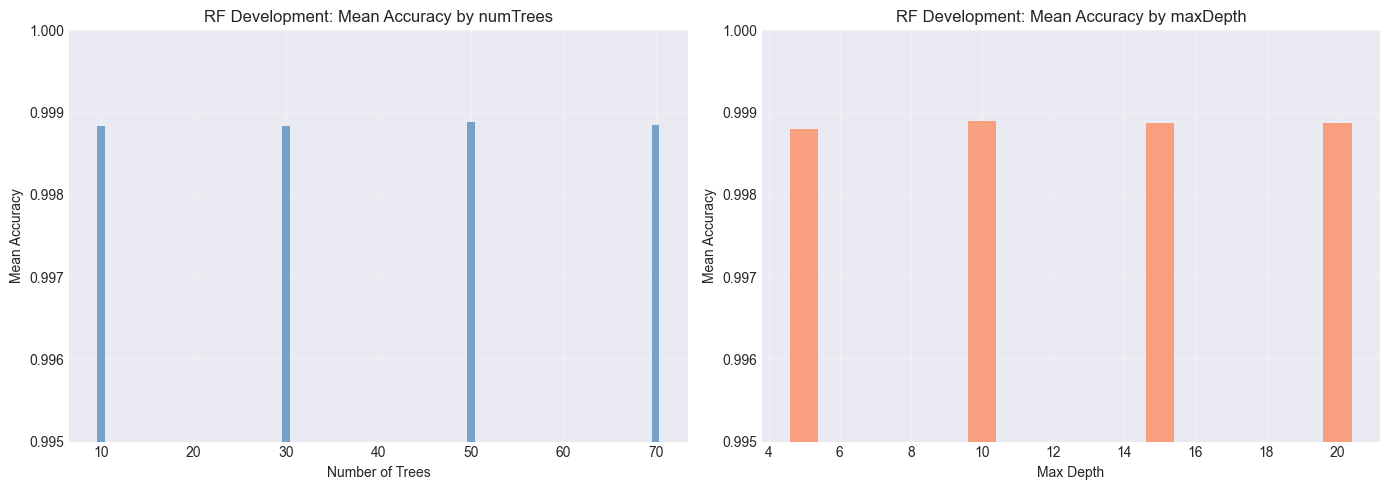


SAVING DEVELOPMENT RESULTS (RF)

Saved: 04_rf_development_tuning.csv
  Rows: 16
  Columns: ['run_name', 'model_type', 'numTrees', 'maxDepth', 'featureSubsetStrategy', 'accuracy', 'f1', 'train_time']

SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION (RF)

1. numTrees=50, maxDepth=20
  Development accuracy: 0.9989
  Development F1: 0.9989
  Development train time: 9.7s

2. numTrees=50, maxDepth=10
  Development accuracy: 0.9989
  Development F1: 0.9989
  Development train time: 3.2s

3. numTrees=50, maxDepth=15
  Development accuracy: 0.9989
  Development F1: 0.9989
  Development train time: 5.3s


CLEANUP

Caches cleared
Spark Session stopped


In [17]:
# DEVELOPMENT RESULTS

print("=" * 70)
print("COLLECTING DEVELOPMENT RESULTS (RF)")
print("=" * 70 + "\n")

# Get runs
rf_dev_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'development'" 
)

# Extract run data
runs_data = []
for run in rf_dev_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)
runs_data
len(runs_data)

# Convert to DataFrame
results_dev_rf_df = pd.DataFrame(runs_data)
results_dev_rf_df['numTrees']=results_dev_rf_df['numTrees'].astype(int)
results_dev_rf_df['maxDepth']=results_dev_rf_df['maxDepth'].astype(int)

# Sort by accuracy (descending - higher is better)
results_dev_rf_df = results_dev_rf_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

print(f"Total configurations tested: {len(results_dev_rf_df)}")
print(f"\nAll configurations (sorted by accuracy):")
print(results_dev_rf_df.to_string(index=False))

# Statistics
print(f"\nResults statistics:")
print(f"  Best accuracy: {results_dev_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_dev_rf_df['accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_dev_rf_df['accuracy'].mean():.4f}")
print(f"  Std accuracy: {results_dev_rf_df['accuracy'].std():.4f}")
print(f"  Avg train time: {results_dev_rf_df['train_time'].mean():.1f}s")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by numTrees
ax1 = axes[0]
trees_groups = results_dev_rf_df.groupby('numTrees')['accuracy'].mean().sort_index()
ax1.bar(trees_groups.index, trees_groups.values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Mean Accuracy')
ax1.set_title('RF Development: Mean Accuracy by numTrees')
ax1.set_ylim(0.995, 1)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy by maxDepth
ax2 = axes[1]
depth_groups = results_dev_rf_df.groupby('maxDepth')['accuracy'].mean().sort_index()
ax2.bar(depth_groups.index, depth_groups.values, color='coral', alpha=0.7)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Mean Accuracy')
ax2.set_title('RF Development: Mean Accuracy by maxDepth')
ax2.set_ylim(0.995, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_development_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved PNG: 04_rf_development_analysis.png")
plt.show()

print("\n" + "=" * 70)
print("SAVING DEVELOPMENT RESULTS (RF)")
print("=" * 70 + "\n")

# Save complete results
results_dev_rf_df.to_csv(RESULTS_DIR / '04_rf_development_tuning.csv', index=False)
print(f"Saved: {'04_rf_development_tuning.csv'}")
print(f"  Rows: {len(results_dev_rf_df)}")
print(f"  Columns: {list(results_dev_rf_df.columns)}")

print("\n" + "=" * 70)
print("SELECTING TOP 3 CONFIGURATIONS FOR PRODUCTION (RF)")
print("=" * 70 + "\n")

# Select Top 3 Configurations
top_rf_runs=client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'development'",
    order_by=[f"metrics.accuracy DESC"],
    max_results=3 
)

for i, run in enumerate(top_rf_runs, 1):
    print(f"{i}. numTrees={run.data.params['numTrees']}, maxDepth={run.data.params['maxDepth']}")
    print(f"  Development accuracy: {run.data.metrics['accuracy']:.4f}")
    print(f"  Development F1: {run.data.metrics['f1']:.4f}")
    print(f"  Development train time: {run.data.metrics['train_time']:.1f}s\n")


# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("=" * 70 + "\n")

train_dev_rf.unpersist()
test_dev_rf.unpersist()
train_dev_rf_transformed.unpersist()
test_dev_rf_transformed.unpersist()
customers_dev.unpersist()
print("Caches cleared")
spark.stop()
print("Spark Session stopped")

# Random Forest Production Phase

## Production Training - Full Dataset

La fase di production ri-train le **top 3 configurazioni** identificate in development su **100% del dataset**.

## MLflow Tracking

Ogni run sarà tracciato con:
- **Tag**: `phase=development`, `sample_fraction=1.0`, `model_path`
- **Params**: numTrees, maxDepth
- **Metrics**: Accuracy, F1, train_time

In [18]:
# SPARK SESSION CREATION

print("\n" + "=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70 + "\n")

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")


SPARK SESSION CREATION

Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Spark session created successfully


In [19]:
# LOAD & SPLIT FULL DATA (10%0)

print("=" * 70)
print("RF PRODUCTION PHASE (100% DATA)")
print("=" * 70 + "\n")

print("Loading full customer dataset for production training...")
start_time = time.time()

print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"Loaded {customers_count:,} customer records")
    print(f"Schema: {customers_full.columns}")
    customers_full.printSchema()
    
    # Sample preview
    print("\nSample data:")
    customers_full.show(5, truncate=False)
    
    # Class distribution
    print("\nClass distribution:")
    customers_full.groupBy("customer_segment").count().orderBy("count", ascending=False).show()
    
except Exception as e:
    print(f"  Error loading customers: {e}")
    raise

load_time = time.time() - start_time

print(f"  Full dataset ready: {customers_count:,} customers")
print(f"  Verification time: {load_time:.1f} seconds")

# Compare with development
dev_customers_recorded = int(customers_count * SAMPLE_FRACTION_DEV)
print(f"\nData comparison:")
print(f"  Development (20%): ~{dev_customers_recorded:,} customers")
print(f"  Production (100%): {customers_count:,} customers")
print(f"  Scale factor: {customers_count/dev_customers_recorded:.1f}x")

print("\n" + "=" * 70)
print("TRAIN/TEST SPLIT (PRODUCTION)")
print("=" * 70 + "\n")

print(f"Splitting full data ({TRAIN_RATIO}/{TEST_RATIO})...")
train_prod_rf, test_prod_rf = customers_full.randomSplit([TRAIN_RATIO, TEST_RATIO], seed=RANDOM_SEED)

# No count yet - will count during caching
print("  Split complete")

RF PRODUCTION PHASE (100% DATA)

Loading full customer dataset for production training...

Loading customer features...
Loaded 1,000,000 customer records
Schema: ['customer_id', 'recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'customer_segment', 'age', 'region']
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)


  Sample data:
+-----------+-------+---------+------------------+------------------+---------------+----------------+---+-------------+
|customer_id|recency|frequency|monetary          |avg_transaction   |unique_products|customer_segment|age|region       |
+-----------+-------+---------+------------------+------------------+--

In [20]:
# TRANSFORM FEATURES

print("=" * 70)
print("APPLYING FEATURE TRANSFORMATIONS (PRODUCTION)")
print("=" * 70 + "\n")

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']
categorical_features = ['region']


# Fit indexers on full training data
print("Fitting StringIndexers on production data...")
string_indexer_prod = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)
string_indexer_model_prod = string_indexer_prod.fit(train_prod_rf)

label_indexer_prod = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)
label_indexer_model_prod = label_indexer_prod.fit(train_prod_rf)

# Assembler (same as development)
assembler_prod = VectorAssembler(
    inputCols=numeric_features + ["region_indexed"],
    outputCol="features",
    handleInvalid="keep"
)

# Transform train
print("\nTransforming train set...")
train_prod_rf_indexed = string_indexer_model_prod.transform(train_prod_rf)
train_prod_rf_indexed = label_indexer_model_prod.transform(train_prod_rf_indexed)
train_prod_rf_transformed = assembler_prod.transform(train_prod_rf_indexed)
train_prod_rf_transformed.cache()

train_prod_rf_count = train_prod_rf_transformed.count()
print(f"  Train transformed and cached: {train_prod_rf_count:,} customers")

# Transform test
print("\nTransforming test set...")
test_prod_rf_indexed = string_indexer_model_prod.transform(test_prod_rf)
test_prod_rf_indexed = label_indexer_model_prod.transform(test_prod_rf_indexed)
test_prod_rf_transformed = assembler_prod.transform(test_prod_rf_indexed)
test_prod_rf_transformed.cache()

test_prod_rf_count = test_prod_rf_transformed.count()
print(f"  Test transformed and cached: {test_prod_rf_count:,} customers")

# Split verification
total_prod_rf = train_prod_rf_count + test_prod_rf_count
print(f"\nSplit verification:")
print(f"  Train: {train_prod_rf_count:,} ({train_prod_rf_count/total_prod_rf*100:.1f}%)")
print(f"  Test: {test_prod_rf_count:,} ({test_prod_rf_count/total_prod_rf*100:.1f}%)")
print(f"  Total: {total_prod_rf:,}")

APPLYING FEATURE TRANSFORMATIONS (PRODUCTION)

Fitting StringIndexers on production data...

Transforming train set...
  Train transformed and cached: 799,592 customers

Transforming test set...
  Test transformed and cached: 200,408 customers

Split verification:
  Train: 799,592 (80.0%)
  Test: 200,408 (20.0%)
  Total: 1,000,000


In [21]:
# TRAIN PRODUCTION MODELS

print("=" * 70)
print("TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)")
print("=" * 70 + "\n")

# Initialize results storage
results_prod_rf = []

# Evaluators (production)
acc_evaluator_prod = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

f1_evaluator_prod = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

for i, run in enumerate(top_rf_runs, 1):

    numTrees = int(run.data.params['numTrees'])
    maxDepth = int(run.data.params['maxDepth'])

    run_name = f"RF_prod_t{numTrees}_d{maxDepth}"

    print(f"\n[{i}/{TOP_N}] Training: {run_name}")
    print(f"  Config from development: Accuracy={run.data.metrics['accuracy']:.4f}\n")

    # Train
    train_start = time.time()
    
    rf = RandomForestClassifier(
        numTrees=numTrees,
        maxDepth=maxDepth,
        featuresCol="features",
        labelCol="label",
        seed=RANDOM_SEED,
        featureSubsetStrategy="auto"
    )
    
    model = rf.fit(train_prod_rf_transformed)
    train_time = time.time() - train_start
    
    # Evaluate
    predictions = model.transform(test_prod_rf_transformed)    
    accuracy = acc_evaluator_prod.evaluate(predictions)
    f1 = f1_evaluator_prod.evaluate(predictions)
    
    # Tags
    tags = {
        "phase": "production",
        "model_type": "RandomForest",
        "sample_fraction": 1.0
    }

    # Params
    params = {
        "numTrees": numTrees,
        "maxDepth": maxDepth,
        "featureSubsetStrategy": "auto"
    }

    # Metrics
    metrics ={
        "accuracy": accuracy,
        "f1": f1,
        "train_time": train_time
    }

    # Log model
    log_model(
        run_name=run_name, 
        model_name="RF_prod", 
        model=model, 
        metrics=metrics, 
        params=params, 
        tags=tags
    )    

    # Store results
    results_prod_rf.append({
        'numTrees': numTrees,
        'maxDepth': maxDepth,
        'accuracy': accuracy,
        'f1': f1,
        'train_time': train_time
    })
    
    print("\n  Metrics:")
    print(f"    Accuracy={accuracy:.4f}, F1={f1:.4f}, Time={train_time:.1f}s")
    

TRAINING PRODUCTION MODELS (TOP 3 CONFIGS)


[1/3] Training: RF_prod_t50_d20
  Config from development: Accuracy=0.9989

  Spark model logged to MLflow
    Run ID: 38f5770017a149a99668b7bb276b59c5
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/38f5770017a149a99668b7bb276b59c5/

  Metrics:
    Accuracy=0.9984, F1=0.9984, Time=26.8s

[2/3] Training: RF_prod_t50_d10
  Config from development: Accuracy=0.9989

  Spark model logged to MLflow
    Run ID: 17704b8964c142d7831cbdee047927a5
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/17704b8964c142d7831cbdee047927a5/

  Metrics:
    Accuracy=0.9984, F1=0.9984, Time=9.8s

[3/3] Training: RF_prod_t50_d15
  Config from development: Accuracy=0.9989

  Spark model logged to MLflow
    Run ID: f3f928b4bd9a4e8da463ece76b066609
    Artifacts in MinIO: s3://bigdata-ecommerce/mlflow-artifacts/f3f928b4bd9a4e8da463ece76b066609/

  Metrics:
    Accuracy=0.9984, F1=0.9984, Time=16.6s


## Analisi Risultati Production

Confrontiamo i risultati production con development per validare la nostra strategia.

Selezioniamo il **best production model** basandoci su:
1. **Accuracy** : Valore più alto
2. **Stability**: Performance consistente tra development e production
3. **Efficiency**: A parità di Accuracy, preferiamo model più veloce

In [22]:
# PRODUCTION RESULTS

print("=" * 70)
print("PRODUCTION RESULTS COLLECTION (RF)")
print("=" * 70 + "\n")

# Convert to DataFrame
results_prod_rf_df = pd.DataFrame(results_prod_rf)

# Sort by accuracy
results_prod_rf_df = results_prod_rf_df.sort_values('accuracy', ascending=False).reset_index(drop=True)

print("Production training complete!")
print(f"\nAll production results:")
print(results_prod_rf_df.to_string(index=False))

# Statistics
print(f"\nProduction statistics:")
print(f"  Best accuracy: {results_prod_rf_df['accuracy'].max():.4f}")
print(f"  Worst accuracy: {results_prod_rf_df['accuracy'].min():.4f}")
print(f"  Mean accuracy: {results_prod_rf_df['accuracy'].mean():.4f}")
print(f"  Total training time: {results_prod_rf_df['train_time'].sum():.1f}s ({results_prod_rf_df['train_time'].sum()/60:.1f} min)")

print("\n" + "=" * 70)
print("PRODUCTION VS DEVELOPMENT COMPARISON (RF)")
print("=" * 70)

# Create comparison DataFrame
comparison_data_rf = []
for i, prod_row in results_prod_rf_df.iterrows():
    # Find corresponding dev row
    dev_row = results_dev_rf_df[
        (results_dev_rf_df['numTrees'] == prod_row['numTrees']) &
        (results_dev_rf_df['maxDepth'] == prod_row['maxDepth'])
    ].iloc[0]
    
    comparison_data_rf.append({
        'numTrees': prod_row['numTrees'],
        'maxDepth': prod_row['maxDepth'],
        'dev_accuracy': dev_row['accuracy'],
        'prod_accuracy': prod_row['accuracy'],
        'accuracy_diff': prod_row['accuracy'] - dev_row['accuracy'],
        'dev_time': dev_row['train_time'],
        'prod_time': prod_row['train_time'],
        'time_factor': prod_row['train_time'] / dev_row['train_time']
    })

comparison_rf_df = pd.DataFrame(comparison_data_rf)

print("Development vs Production comparison:")
print(comparison_rf_df.to_string(index=False))

print(f"\nKey insights:")
print(f"  Avg accuracy difference: {comparison_rf_df['accuracy_diff'].mean():.4f}")
print(f"  Avg time factor (prod/dev): {comparison_rf_df['time_factor'].mean():.1f}x")
print(f"  Accuracy correlation: {comparison_rf_df[['dev_accuracy', 'prod_accuracy']].corr().iloc[0, 1]:.3f}")

# Save comparison
comparison_rf_df.to_csv(RESULTS_DIR / '04_rf_dev_vs_prod_comparison.csv', index=False)
print("\nSaved CSV: 04_rf_dev_vs_prod_comparison.csv")

print("\n" + "=" * 70)
print("SAVING PRODUCTION RESULTS (RF)")
print("=" * 70 + "\n")

# Save production results
results_prod_rf_df.to_csv(RESULTS_DIR / '04_rf_production_final.csv', index=False)
print(f"Saved csv: 04_rf_production_final.csv")

# Cleanup
print("\n" + "=" * 70)
print("CLEANUP")
print("=" * 70 + "\n")
print("Unpersisting cached datasets...")
train_prod_rf_transformed.unpersist()
test_prod_rf_transformed.unpersist()
print("Caches cleared")
spark.stop()
print("Spark Session stopped")

PRODUCTION RESULTS COLLECTION (RF)

Production training complete!

All production results:
 numTrees  maxDepth  accuracy       f1  train_time
       50        15  0.998373 0.998378   16.630328
       50        20  0.998363 0.998367   26.785936
       50        10  0.998363 0.998372    9.822664

Production statistics:
  Best accuracy: 0.9984
  Worst accuracy: 0.9984
  Mean accuracy: 0.9984
  Total training time: 53.2s (0.9 min)

PRODUCTION VS DEVELOPMENT COMPARISON (RF)
Development vs Production comparison:
 numTrees  maxDepth  dev_accuracy  prod_accuracy  accuracy_diff  dev_time  prod_time  time_factor
     50.0      15.0      0.998899       0.998373      -0.000526  5.253564  16.630328     3.165533
     50.0      20.0      0.998924       0.998363      -0.000561  9.701636  26.785936     2.760971
     50.0      10.0      0.998924       0.998363      -0.000561  3.193378   9.822664     3.075947

Key insights:
  Avg accuracy difference: -0.0005
  Avg time factor (prod/dev): 3.0x
  Accuracy 

# Selezione Modelli

## Modelli in MLflow

In questa parte analizziamo **tutti** gli esperimenti tracciati in MLflow per selezionare i modelli migliori.

### Esperimenti Totali

**Experiment name**: `ecommerce-ml-models`

**Runs attesi**:
- ALS Development: 27 runs (grid search)
- ALS Production: 3 runs (top configs)
- RF Development: 16 runs (grid search)
- RF Production: 3 runs (top configs)
- **Totale**: 49 runs

### Organizzazione Runs

**Tags usati per filtrare**:
- `phase`: "development" o "production"
- `model_type`: "ALS" o "RandomForest"
- `sample_fraction`: 0.2 o 1.0

**MLflow Runs**

<img src="./screenshots/04_mlflow_runs.png" alt="MLFlow Runs" >

**MinIO Runs**

<img src="./screenshots/04_minio_runs.png" alt="MinIO Runs" >




## Confronto Modelli ALS

Compariamo i 3 modelli ALS production per selezionare il migliore secondo i criteri:

1. **RMSE più basso** (primary)
2. **Training time ragionevole** (se performance simile)
3. **Configurazione sensata** (non estrema)

### Threshold di Successo

**RMSE < 1.0**: Buono (rating range 0-5, errore <20%)  
**RMSE < 0.8**: Eccellente  
**RMSE < 0.5**: Outstanding (difficile da raggiungere)  

## Confronto Modelli RF

Compariamo i 3 modelli Random Forest production per selezionare il migliore secondo i criteri:

1. **Accuracy più alta** (primary)
2. **F1 VIP alto** (business critical)
3. **Performance stabile** tra train e test
4. **Efficiency** (se accuracy simile, preferiamo meno trees/depth)

### Threshold di Successo

**Accuracy > 85%**: Minimo accettabile (> baseline 60%)  
**Accuracy > 90%**: Buono  
**Accuracy > 95%**: Eccellente  

ALS MODELS COMPARISON (PRODUCTION)

Production ALS models (sorted by RMSE):
               run_name rank maxIter regParam     rmse      mae  train_time
ALS_prod_r10_i20_reg0.1   10      20      0.1 0.473246 0.316133  238.944026
ALS_prod_r15_i15_reg0.1   15      15      0.1 0.472508 0.315357  235.754891
ALS_prod_r15_i20_reg0.1   15      20      0.1 0.473494 0.316392  303.448451

ALS Statistics:
  Best RMSE: 0.4725
  Worst RMSE: 0.4735
  Mean RMSE: 0.4731
  RMSE range: 0.0010

ALS METRICS VISUALIZATION

Saved PNG: 04_als_production_comparison.png


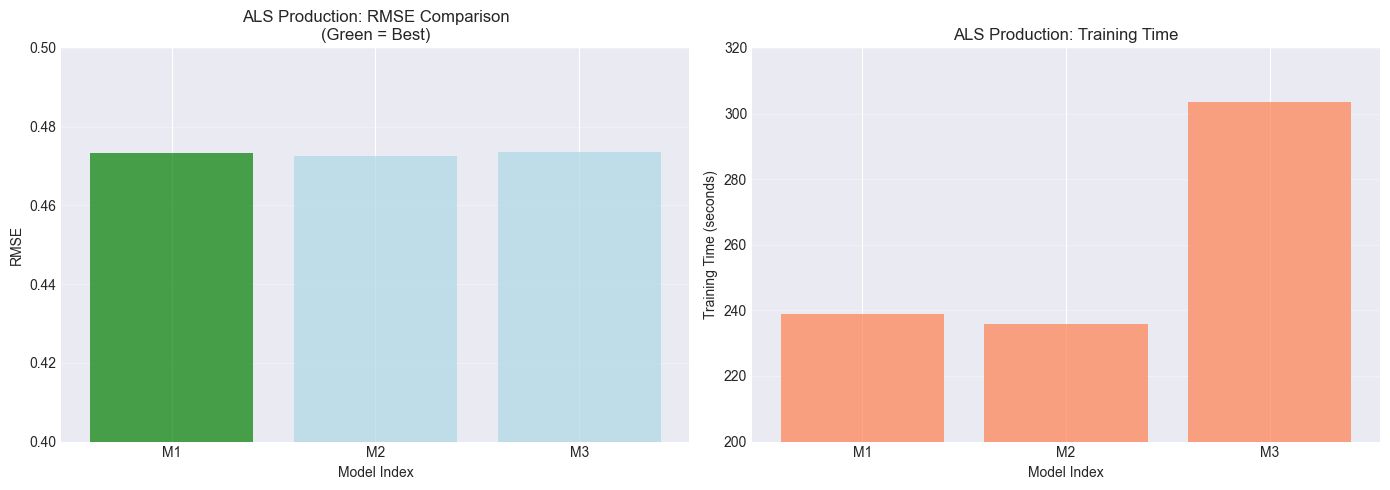

In [23]:
# ALS COMPARISON TABLE

print("=" * 70)
print("ALS MODELS COMPARISON (PRODUCTION)")
print("=" * 70 + "\n")

# Get runs
als_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'production'" 
)

# Extract run data
runs_data = []
for run in als_prod_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)
runs_data
len(runs_data)

als_comparison = pd.DataFrame(runs_data)
als_comparison.sort_values(by='rmse', ascending=True)

# Display comparison table
print("Production ALS models (sorted by RMSE):")
print(als_comparison[['run_name', 'rank', 'maxIter', 'regParam', 'rmse', 'mae', 'train_time']].to_string(index=False))

# Statistics
print(f"\nALS Statistics:")
print(f"  Best RMSE: {als_comparison['rmse'].min():.4f}")
print(f"  Worst RMSE: {als_comparison['rmse'].max():.4f}")
print(f"  Mean RMSE: {als_comparison['rmse'].mean():.4f}")
print(f"  RMSE range: {als_comparison['rmse'].max() - als_comparison['rmse'].min():.4f}")

print("\n" + "=" * 70)
print("ALS METRICS VISUALIZATION")
print("=" * 70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE by rank
ax1 = axes[0]
for idx, row in als_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax1.bar(idx, row['rmse'], color=color, alpha=0.7)
ax1.set_xlabel('Model Index')
ax1.set_ylabel('RMSE')
ax1.set_title('ALS Production: RMSE Comparison\n(Green = Best)')
ax1.set_xticks(range(len(als_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax1.set_ylim(0.4, 0.5)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Training time
ax2 = axes[1]
ax2.bar(range(len(als_comparison)), als_comparison['train_time'], color='coral', alpha=0.7)
ax2.set_xlabel('Model Index')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('ALS Production: Training Time')
ax2.set_xticks(range(len(als_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(als_comparison))])
ax2.set_ylim(200, 320)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_als_production_comparison.png', dpi=300, bbox_inches='tight')
print("Saved PNG: 04_als_production_comparison.png")
plt.show()


RF MODELS COMPARISON (PRODUCTION)

Production RF models (sorted by Accuracy):
       run_name numTrees maxDepth  accuracy       f1  train_time
RF_prod_t50_d15       50       15  0.998373 0.998378   16.630328
RF_prod_t50_d10       50       10  0.998363 0.998372    9.822664
RF_prod_t50_d20       50       20  0.998363 0.998367   26.785936

RF Statistics:
  Best Accuracy: 0.9984
  Worst Accuracy: 0.9984
  Mean Accuracy: 0.9984
  Accuracy range: 0.0000

RF METRICS VISUALIZATION

Saved PNG: 04_rf_production_comparison.png


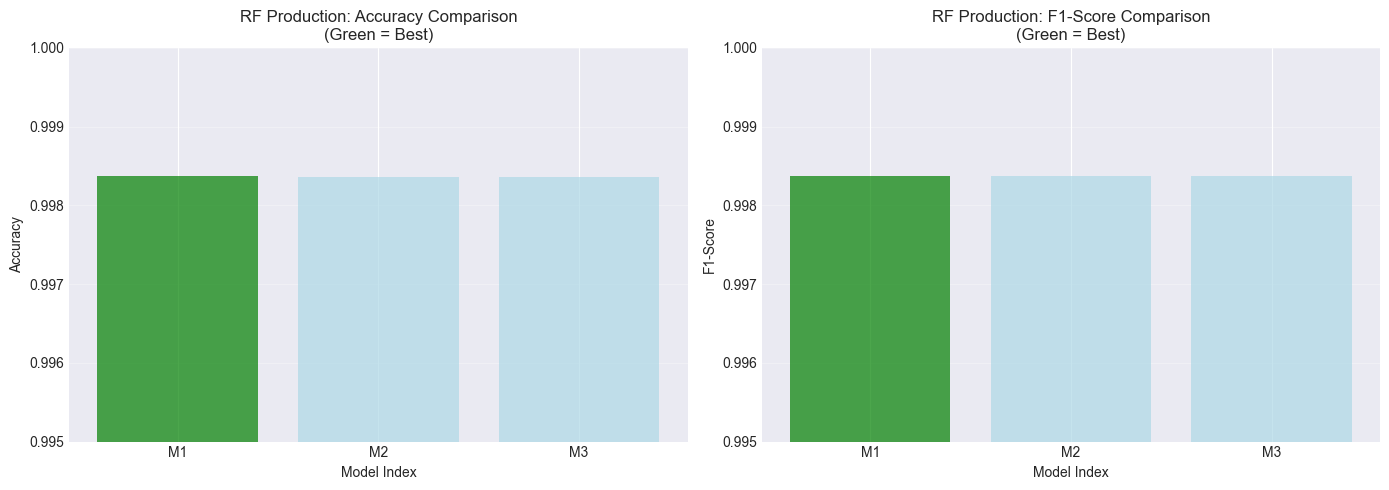

In [24]:
# RF COMPARISON TABLE

print("=" * 70)
print("RF MODELS COMPARISON (PRODUCTION)")
print("=" * 70 + "\n")

# Get runs
rf_prod_runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'production'" 
)

# Extract run data
runs_data = []
for run in rf_prod_runs:

    run_data = {
        'run_name': run.info.run_name,
    }
    # Add tags
    run_data['model_type'] = run.data.tags['model_type']

    # Add params
    for key, value in run.data.params.items():
        run_data[f'{key}'] = value
    
    # Add metrics
    for key, value in run.data.metrics.items():
        run_data[f'{key}'] = value
    
    runs_data.append(run_data)

rf_comparison = pd.DataFrame(runs_data)
rf_comparison.sort_values(by='accuracy', ascending=True)

# Display comparison table
print("Production RF models (sorted by Accuracy):")
print(rf_comparison[['run_name', 'numTrees', 'maxDepth', 'accuracy', 'f1', 'train_time']].to_string(index=False))

# Statistics
print(f"\nRF Statistics:")
print(f"  Best Accuracy: {rf_comparison['accuracy'].max():.4f}")
print(f"  Worst Accuracy: {rf_comparison['accuracy'].min():.4f}")
print(f"  Mean Accuracy: {rf_comparison['accuracy'].mean():.4f}")
print(f"  Accuracy range: {rf_comparison['accuracy'].max() - rf_comparison['accuracy'].min():.4f}")

print("\n" + "=" * 70)
print("RF METRICS VISUALIZATION")
print("=" * 70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
ax1 = axes[0]
for idx, row in rf_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax1.bar(idx, row['accuracy'], color=color, alpha=0.7)
ax1.set_xlabel('Model Index')
ax1.set_ylabel('Accuracy')
ax1.set_title('RF Production: Accuracy Comparison\n(Green = Best)')
ax1.set_xticks(range(len(rf_comparison)))
ax1.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax1.set_ylim(0.995, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: F1 vs AUC
ax2 = axes[1]
for idx, row in rf_comparison.iterrows():
    color = 'green' if idx == 0 else 'lightblue'
    ax2.bar(idx, row['f1'], color=color, alpha=0.7)
ax2.set_xlabel('Model Index')
ax2.set_ylabel('F1-Score')
ax2.set_title('RF Production: F1-Score Comparison\n(Green = Best)')
ax2.set_xticks(range(len(rf_comparison)))
ax2.set_xticklabels([f"M{i+1}" for i in range(len(rf_comparison))])
ax2.set_ylim(0.995, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_production_comparison.png', dpi=300, bbox_inches='tight')
print("Saved PNG: 04_rf_production_comparison.png")
plt.show()


In [25]:
# SELECT & REGISTRY BEST MODEL

print("=" * 70)
print("BEST MODEL SELECTION")
print("=" * 70 + "\n")

# Best ALS model (lowest RMSE)
best_als = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'ALS' AND tags.phase = 'production'",
    order_by=["metrics.rmse ASC"],
    max_results=1 
)[0]

print("\nBEST ALS MODEL:")
print(f"  Run name:   {best_als.info.run_name}")
print(f"  Run ID: {best_als.info.run_id}")
print(f"  Configuration:")
print(f"    - rank:     {int(best_als.data.params['rank'])}")
print(f"    - maxIter:  {int(best_als.data.params['maxIter'])}")
print(f"    - regParam: {float(best_als.data.params['regParam'])}")
print(f"  Performance:")
print(f"    - RMSE: {best_als.data.metrics['rmse']:.4f}")
print(f"    - MAE:  {best_als.data.metrics['mae']:.4f}")


# Best RF model (highest accuracy)
best_rf = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="tags.model_type = 'RandomForest' AND tags.phase = 'production'",
    order_by=["metrics.accuracy DESC"],
    max_results=1 
)[0]

print("\nBEST RF MODEL:")
print(f"  Run name: {best_rf.info.run_name}")
print(f"  Run ID: {best_rf.info.run_id}")
print(f"  Configuration:")
print(f"    - numTrees: {int(best_rf.data.params['numTrees'])}")
print(f"    - maxDepth: {int(best_rf.data.params['maxDepth'])}")
print(f"  Performance:")
print(f"    - Accuracy: {best_rf.data.metrics['accuracy']:.4f}")
print(f"    - F1:       {best_rf.data.metrics['f1']:.4f}")


print("\n" + "=" * 70)
print("MLFLOW MODEL REGISTRY")
print("=" * 70 + "\n")

print("Registering best models in MLflow Model Registry...")

try:
    # Register best ALS model
    print("\n[1/2] Registering ALS model...")
    als_model_uri = f"s3://bigdata-ecommerce/mlflow-artifacts/{best_als.info.run_id}/artifacts/ALS_prod"
    als_model_name = "ALS_Recommender_Production"
    
    als_mv = mlflow.register_model(als_model_uri, als_model_name)
    print(f"  Registered: {als_model_name}")
    print(f"  Version: {als_mv.version}")
    print(f"  Run ID: {best_als.info.run_id}")
    
    # Register best RF model
    print("\n[2/2] Registering RF model...")
    rf_model_uri = f"s3://bigdata-ecommerce/mlflow-artifacts/{best_rf.info.run_id}/artifacts/RF_prod"
    rf_model_name = "RF_Classifier_Production"
    
    rf_mv = mlflow.register_model(rf_model_uri, rf_model_name)
    print(f"  Registered: {rf_model_name}")
    print(f"  Version: {rf_mv.version}")
    print(f"  Run ID: {best_rf.info.run_id}")
    
except Exception as e:
    print(f"  Warning: Model registration failed: {e}")


BEST MODEL SELECTION


BEST ALS MODEL:
  Run name:   ALS_prod_r15_i15_reg0.1
  Run ID: fde160d54d6c460e8864d8d1256fd2be
  Configuration:
    - rank:     15
    - maxIter:  15
    - regParam: 0.1
  Performance:
    - RMSE: 0.4725
    - MAE:  0.3154

BEST RF MODEL:
  Run name: RF_prod_t50_d15
  Run ID: f3f928b4bd9a4e8da463ece76b066609
  Configuration:
    - numTrees: 50
    - maxDepth: 15
  Performance:
    - Accuracy: 0.9984
    - F1:       0.9984

MLFLOW MODEL REGISTRY

Registering best models in MLflow Model Registry...

[1/2] Registering ALS model...


Successfully registered model 'ALS_Recommender_Production'.
2026/02/05 23:59:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ALS_Recommender_Production, version 1
Created version '1' of model 'ALS_Recommender_Production'.
Successfully registered model 'RF_Classifier_Production'.
2026/02/05 23:59:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RF_Classifier_Production, version 1


  Registered: ALS_Recommender_Production
  Version: 1
  Run ID: fde160d54d6c460e8864d8d1256fd2be

[2/2] Registering RF model...
  Registered: RF_Classifier_Production
  Version: 1
  Run ID: f3f928b4bd9a4e8da463ece76b066609


Created version '1' of model 'RF_Classifier_Production'.


# Production Deployment 

Tutti i modelli sono salvati in MLflow e possono essere caricati e utilizzati per eseguire predizioni su larga scala.

1. **ALS: Recommendations Generation**
   - **Input**: User-Item matrix (tutti gli users)  
   - **Output**: Top-N items per user  
   - **Method**: `model.recommendForAllUsers(N)`  

2. **RF: Customer Segmentation**
   - **Input**: Customer features (tutti i customers)  
   - **Output**: Segment prediction + probability  
   - **Method**: `model.transform(features_df)`  

Eseguiremo le predizioni con  modelli precedentemente selezionati.

In [26]:
# SPARK SESSION CREATION

print("=" * 70)
print("SPARK SESSION CREATION")
print("=" * 70 + "\n")

# Create Spark session using config
spark = get_spark_session("Notebook-04-PySpark-MLflow")

# Verify Spark is working
spark.sparkContext.setLogLevel("ERROR")

# Test basic operation
test_df = spark.range(10)
assert test_df.count() == 10, "Spark basic operation failed"

print("\nSpark session created successfully")

SPARK SESSION CREATION

Found 4 JAR files
Spark Session created: Notebook-04-PySpark-MLflow
Spark Version: 3.4.1
Spark UI: http://localhost:4040
Delta Lake + MinIO: Enabled

Spark session created successfully


In [27]:
# PREDICTIONS ALS

print("=" * 70)
print("BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER")
print("=" * 70 + "\n")

# Load ALS model
print("\nLoading ALS model...")

try:
    loaded_als_model = mlflow.spark.load_model(als_model_uri)
    als_model = loaded_als_model.stages[-1]
    print(f"  ALS model loaded successfully")
    print(f"  Type: {type(loaded_als_model)}")
    print(f"  Last Stage: {type(als_model)}")  
    
except Exception as e:
    print(f"  Error loading ALS model: {e}")


print("\nGenerating recommendations for all users (batch processing)...")

# Use loaded model
print("\n[1/2] Generate Top-10 recommendations for all users")

start_time = time.time()

user_recs = als_model.recommendForAllUsers(10)
total_users = user_recs.count()

rec_time = time.time() - start_time

print(f"  Generated recommendations for {total_users:,} users in {rec_time:.1f}s")
print(f"  Throughput: {total_users/rec_time:.0f} users/second")

# Show sample
print("\nSample recommendations:")
user_recs.show(5, truncate=False)

# Explode recommendations array for analysis
print("\nExploding recommendations for analysis...")

recs_exploded = user_recs.select(
    F.col("user_id"),
    F.explode(F.col("recommendations")).alias("recommendation")
).select(
    F.col("user_id"),
    F.col("recommendation.item_id").alias("item_id"),
    F.col("recommendation.rating").alias("predicted_rating")
)

print("Recommendations exploded")
print(f"  Total recommendations: {recs_exploded.count():,}")

# Show sample
print("\nSample exploded recommendations:")
recs_exploded.show(10, truncate=False)

# Save to Delta Lake for production serving
print("\n[2/2] Saving recommendations to Delta Lake...")
recs_output_path = f"{DATA_PATHS['predictions']}/recommendations_output"

try:
    recs_exploded.write.format("delta").mode("overwrite").save(recs_output_path)
    print(f"Saved to: {recs_output_path}")
except Exception as e:
    print(f"Could not save to Delta Lake: {e}")

print("\nBatch predictions pipeline complete")


BATCH PREDICTIONS PIPELINE - ALS RECOMMENDER


Loading ALS model...


2026/02/05 23:59:50 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2026/02/05 23:59:51 INFO mlflow.spark: URI 's3://bigdata-ecommerce/mlflow-artifacts/fde160d54d6c460e8864d8d1256fd2be/artifacts/ALS_prod/sparkml' does not point to the current DFS.
2026/02/05 23:59:51 INFO mlflow.spark: File 's3://bigdata-ecommerce/mlflow-artifacts/fde160d54d6c460e8864d8d1256fd2be/artifacts/ALS_prod/sparkml' not found on DFS. Will attempt to upload the file.


  ALS model loaded successfully
  Type: <class 'pyspark.ml.pipeline.PipelineModel'>
  Last Stage: <class 'pyspark.ml.recommendation.ALSModel'>

Generating recommendations for all users (batch processing)...

[1/2] Generate Top-10 recommendations for all users
  Generated recommendations for 1,000,000 users in 187.0s
  Throughput: 5348 users/second

Sample recommendations:
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                              |
+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3      |[{1, 6.5237966}, {2, 5.7795696}, {8, 5.415797}, {11, 5.342822}, 

BATCH PREDICTIONS PIPELINE - RF CLASSIFIER


Loading RF model...


2026/02/06 00:15:17 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2026/02/06 00:15:17 INFO mlflow.spark: URI 's3://bigdata-ecommerce/mlflow-artifacts/f3f928b4bd9a4e8da463ece76b066609/artifacts/RF_prod/sparkml' does not point to the current DFS.
2026/02/06 00:15:17 INFO mlflow.spark: File 's3://bigdata-ecommerce/mlflow-artifacts/f3f928b4bd9a4e8da463ece76b066609/artifacts/RF_prod/sparkml' not found on DFS. Will attempt to upload the file.


  RF model loaded successfully
  Type: <class 'pyspark.ml.pipeline.PipelineModel'>
  Last Stage: <class 'pyspark.ml.classification.RandomForestClassificationModel'>

Loading customer features...
Loaded 1,000,000 customer records
Schema: ['customer_id', 'recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'customer_segment', 'age', 'region']
root
 |-- customer_id: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: long (nullable = true)
 |-- monetary: double (nullable = true)
 |-- avg_transaction: double (nullable = true)
 |-- unique_products: long (nullable = true)
 |-- customer_segment: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- region: string (nullable = true)


[1/3] Transform and predict for all customers
  Classified 1,000,000 customers in 0.8s
  Throughput: 1205446 customers/second

[2/3] Prediction distribution:
+-----------+-------+---------+------------------+------------------+---------------+----------

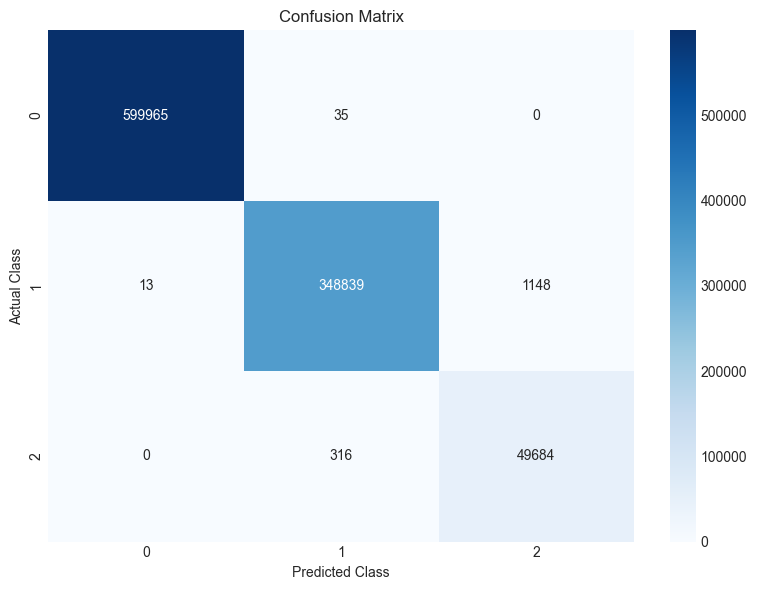


[3/3] Saving predictions to Delta Lake...
Saved to: s3a://bigdata-ecommerce/ml_predictions/customer_segments_output

Batch predictions pipeline complete


In [28]:
# PREDICTIONS RF

print("=" * 70)
print("BATCH PREDICTIONS PIPELINE - RF CLASSIFIER")
print("=" * 70 + "\n")

# Load RF model
print("\nLoading RF model...")

try:
    loaded_rf_model = mlflow.spark.load_model(rf_model_uri)
    rf_model = loaded_rf_model.stages[-1] 
    print(f"  RF model loaded successfully")
    print(f"  Type: {type(loaded_rf_model)}")  
    print(f"  Last Stage: {type(rf_model)}")
except Exception as e:
    print(f"  Error loading RF model: {e}")


print("\nLoading customer features...")
try:
    customers_full = spark.read.format("delta").load(DATA_PATHS['customer_features'])
    customers_count = customers_full.count()
    print(f"Loaded {customers_count:,} customer records")
    print(f"Schema: {customers_full.columns}")
    customers_full.printSchema()
    
except Exception as e:
    print(f"Error loading customers: {e}")
    raise

# Use full customer dataset with features
print("\n[1/3] Transform and predict for all customers")
start_time = time.time()

# Define feature columns
numeric_features = ['recency', 'frequency', 'monetary', 'avg_transaction', 'unique_products', 'age']

# Fit indexers on full data
string_indexer_prod = StringIndexer(
    inputCol="region",
    outputCol="region_indexed",
    handleInvalid="keep"
)
string_indexer_model_prod = string_indexer_prod.fit(customers_full)

label_indexer_prod = StringIndexer(
    inputCol="customer_segment",
    outputCol="label",
    handleInvalid="keep"
)
label_indexer_model_prod = label_indexer_prod.fit(customers_full)

# Assembler (same as development)
assembler_prod = VectorAssembler(
    inputCols=numeric_features + ["region_indexed"],
    outputCol="features",
    handleInvalid="keep"
)

# Transform full dataset
customers_full_indexed = string_indexer_model_prod.transform(customers_full)
customers_full_indexed = label_indexer_model_prod.transform(customers_full_indexed)
customers_full_transformed = assembler_prod.transform(customers_full_indexed)

# Predict
all_predictions = rf_model.transform(customers_full_transformed)
total_customers = all_predictions.count()

pred_time = time.time() - start_time

print(f"  Classified {total_customers:,} customers in {pred_time:.1f}s")
print(f"  Throughput: {total_customers/pred_time:.0f} customers/second")

# Prediction distribution
print("\n[2/3] Prediction distribution:")
all_predictions.show(5)
all_predictions.groupBy("prediction").count().orderBy("prediction").show()


# Confusion Matrix
print("\nConfusion Matrix")

# Convert to RDD for confusion matrix
predictions_and_labels = all_predictions.select("prediction", "label").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictions_and_labels)

# Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.savefig(GRAPH_DIR / '04_rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved PNG: 04_rf_confusion_matrix.png")
plt.show()

# Save to Delta Lake
print("\n[3/3] Saving predictions to Delta Lake...")
preds_output_path = f"{DATA_PATHS['predictions']}/customer_segments_output"

try:
    all_predictions.select("customer_id", "prediction", "probability").write.format("delta").mode("overwrite").save(preds_output_path)
    print(f"Saved to: {preds_output_path}")
except Exception as e:
    print(f"Could not save to Delta Lake: {e}")

print("\nBatch predictions pipeline complete")
spark.stop()

**MinIO Predictions**

<img src="./screenshots/04_minio_pred.png" alt="MinIO predictions" >